## Generate Lorenz Time Series

The Lorenz equations are a system of differential equations which exhibit chaotic behavior. They can be written  
$$\begin{align*}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= x y - \beta z
\end{align*}$$


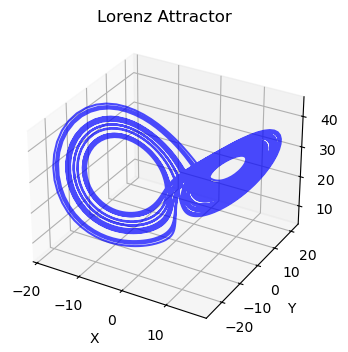

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Define the Lorenz system of differential equations
def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

# Define parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Initial conditions
initial_state = [1.0, 1.0, 1.0]

# Time span
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the system of differential equations
solution = solve_ivp(lorenz, t_span, initial_state, args=(sigma, rho, beta), t_eval=t_eval)

solution.y = solution.y[:,5000:]     # Cut off first values (to ensure that dynamics have approached attractor)

# Plot the time series
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(solution.y[0], solution.y[1], solution.y[2], color='b', alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor')
plt.show()

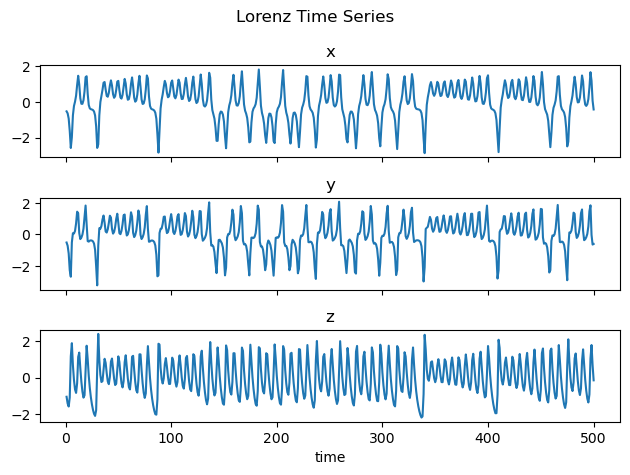

In [5]:
# Format time series into Pandas DataFrame
data = pd.DataFrame(solution['y']).T
data.columns = ['x', 'y', 'z']
data = data[::10].reset_index(drop=True)    # Downsample (to reduce computational time)
data = (data - data.mean()) / data.std()    # Z-score normalize
data['time'] = data.index+1; data = data[['time', 'x', 'y', 'z']]

# Plot time series
fig, axs = plt.subplots(3,1); i = 0; fig.suptitle('Lorenz Time Series')
for col in data.columns[1:]:
    data.plot(ax=axs[i], x='time', y=col, legend=None)
    axs[i].set_title(col)
    if i != 2:
        axs[i].set_xlabel('')
        axs[i].set_xticklabels('')
    i += 1
fig.tight_layout()
plt.show()

In [6]:
# Define unfolding parameters
E = 3
tau = -1

# Define target variable
variable = 'x'

# Create embedding of target variable of dimension E using time lag tau
embedding = pd.DataFrame()
for lag in range(0,E):
    embedding[f'{variable}(t-{str(lag*-1*tau)})'] = data[variable].shift(lag*-1*tau)
embedding

,x(t-0),x(t-1),x(t-2)
0,-0.532819,NaN,NaN
1,-0.642185,-0.532819,NaN
2,-0.935990,-0.642185,-0.532819
3,-1.632543,-0.935990,-0.642185
4,-2.582979,-1.632543,-0.935990
...,...,...,...
495,0.806087,0.152744,-0.133047
496,1.660894,0.806087,0.152744
497,1.179681,1.660894,0.806087
498,0.064095,1.179681,1.660894


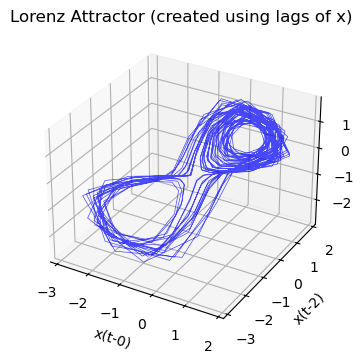

In [8]:
# Plot the attractor reconstruction
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(embedding[embedding.columns[0]], embedding[embedding.columns[1]], embedding[embedding.columns[2]], color='b', alpha=0.7, linewidth=0.5)
ax.set_xlabel('x(t-0)')
ax.set_ylabel('x(t-2)')
ax.set_zlabel('x(t-4)')
ax.set_title('Lorenz Attractor (created using lags of x)')
plt.show()

## Predict time series using Simplex Projection

In [9]:
def univariate_simplex(data, variable, E, Tp, tau):

    # Create embedding of dimension E with time lag tau
    embedding = pd.DataFrame()
    for lag in range(0,E):
        embedding[f'{variable}(t-{str(lag*(-1)*tau)})'] = data[variable].shift(lag*(-1)*tau)

    # Make predictions Tp time steps ahead using Simplex projection
    simplex_result = data[[variable]].copy()
    simplex_result.columns = ['Observations']
    simplex_result['Predictions'] = None

    for index in embedding.index:

        # Get the point we are interested in
        current_point = embedding.iloc[index,:].values

        # Find the E+1 nearest neighbor points
        df = embedding.copy()
        df['dist'] = cdist(current_point[np.newaxis,:], df, metric='euclidean')[0]
        nn_indices = df['dist'][:-E-Tp].nsmallest(E+2).index[1:].tolist()

        # Get weights for weighted average (e^-dist)
        nn_dists = df.loc[nn_indices,'dist'].tolist()
        weights = [np.exp(-w) for w in nn_dists]
        weights = weights / np.sum(weights)

        # Where did the nearest neighbors go in Tp time steps?
        nn_indices_plus_Tp = [t + Tp for t in nn_indices]
        nn_projections = df.iloc[nn_indices_plus_Tp,:]

        # Get our predicted value for our variable at time+Tp (a weighted average of the projected nearest neighbors)
        predicted_point = (nn_projections[variable+'(t-0)']*weights).sum() / weights.sum()

        # Record our prediction
        simplex_result.loc[index+Tp,'Predictions'] = predicted_point
    
    return simplex_result

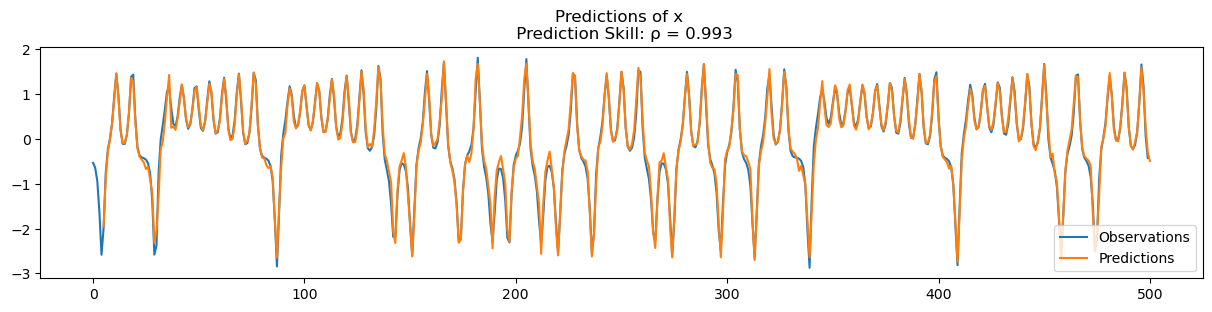

In [30]:
# Make predictions using univariate_simplex
variable = 'x'
E = 3              # Dimension of the state space (number of lags of the variable)
Tp = 1             # How many time steps ahead you want to predict
tau = -2           # Interval of time lag

simplex_result = univariate_simplex(data, variable, E, Tp, tau)
simplex_result.plot(figsize=(15,3), title=f'Predictions of {variable} \n Prediction Skill: ρ = '+str(round(simplex_result.corr().iloc[0,1],3)))
plt.show()

## Predict Time Series Using Cross-Mapping

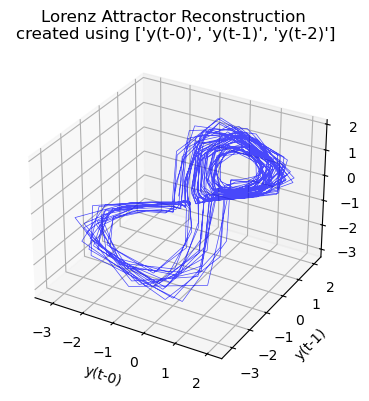

We will use the above attractor reconstruction to make predictions of x


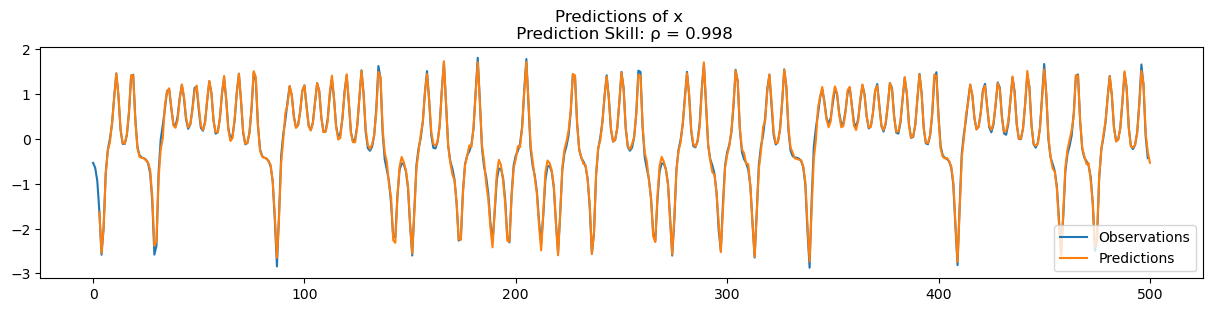

In [40]:
# Use embedding_cols to predict target using cross-mapping
embedding_cols = ['y(t-0)', 'y(t-1)', 'y(t-2)']   # Variables to use in embedding
target         = 'x'                              # Variable to predict
Tp             = 1                                # How many time steps ahead you want to predict
tau            = 1                                # Interval of time lag

# Create a multivariate embedding
embedding = pd.DataFrame()
for col in embedding_cols:
    var = col.split('(')[0]
    lag = col.split('-')[1].split(')')[0]
    embedding[f'{var}(t-{lag})'] = data[var].shift(int(lag))

# Plot the attractor reconstruction
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(embedding[embedding.columns[0]], embedding[embedding.columns[1]], embedding[embedding.columns[2]], color='b', alpha=0.7, linewidth=0.5)
ax.set_xlabel(embedding_cols[0])
ax.set_ylabel(embedding_cols[1])
ax.set_zlabel(embedding_cols[2])
ax.set_title(f'Lorenz Attractor Reconstruction \ncreated using {embedding_cols}')
fig.tight_layout()
plt.show()

print(f'We will use the above attractor reconstruction to make predictions of {target}')

# Make predictions Tp time steps ahead using cross-mapping
xmap_result = data[[target]].copy()
xmap_result.columns = ['Observations']
xmap_result['Predictions'] = None

for index in embedding.index:

    # Get the point we are interested in
    current_point = embedding.iloc[index,:].values

    # Find the E+1 nearest neighbor points
    df = embedding.copy()
    df['dist'] = cdist(current_point[np.newaxis,:], df, metric='euclidean')[0]
    nn_indices = df['dist'][:-E-Tp].nsmallest(E+2).index[1:].tolist()

    # Get weights for weighted average (e^-dist)
    nn_dists = df.loc[nn_indices,'dist'].tolist()
    weights = [np.exp(-w) for w in nn_dists]
    weights = weights / np.sum(weights)

    # Where did the nearest neighbors go in Tp time steps?
    nn_indices_plus_Tp = [t + Tp for t in nn_indices]
    nn_projections = df.iloc[nn_indices_plus_Tp,:]
    
    nn_projections_times = nn_projections.index.tolist()

    ## KEY DIFFERENCE WITH CROSS-MAPPING ##
    # We have found nearest neighbors on the attractor defined by embedding_cols
    # We have idenfified the times associated with those points
    # Now we look at the values of the target variable at those times

    # Get our predicted value for our variable at time+Tp (a weighted average of the projected nearest neighbors)
    predicted_point = (data.loc[nn_projections_times, target]*weights).sum() / weights.sum()

    # Record our prediction
    xmap_result.loc[index+Tp,'Predictions'] = predicted_point
    
xmap_result.plot(figsize=(15,3), title='Predictions of x \n Prediction Skill: ρ = '+str(round(xmap_result.corr().iloc[0,1],3)))
plt.show()